## Gradient descent in presence of extreme flatness and steepness

Typical theoretical analysis of convergence of gradient descent requires assumptions like convexity and smoothness that do not hold in practice. In particular, the theoretical studies for designing good learning rates rarely discuss realistic settings that are highly non-convex. For example, for $L$-Lipschitz and convex functions, the theory suggests the use of a learning rate smaller than $2/L$ as a sufficient condition for convergence. Here we will construct minimalist non-convex and non-smooth examples where this theory fails and setting the learning rate adaptively is necessary.

### Basin sigmoid, a simple class of challenging functions

Towards understanding the challenges and potential solutions for learning in the presence of non-convex non-smooth functions, we will study the convergence of gradient descent for a simple sigmoid-based function family. The functions in this family simultaneously exhibit extreme flatness and extreme sharpness. This makes it particularly challenging to choose a step size.

The function $f(x)$ is constructed using the sigmoid function with temperature, i.e. $\frac{1}{1+e^{\beta x}}$. Here $\beta$ is the temperature parameter that controls the steepness of the function, larger $\beta$ corresponds to higher steepness. Our functions will have two sigmoids added together, and have a second width parameter that controls the width of the basin corresponding to the minimum.
 
$$f(x)=\frac{1}{1+e^{\beta x}}+\frac{1}{1+e^{\beta (w-x)}}$$

We illustrate this function family via the following code snippet.

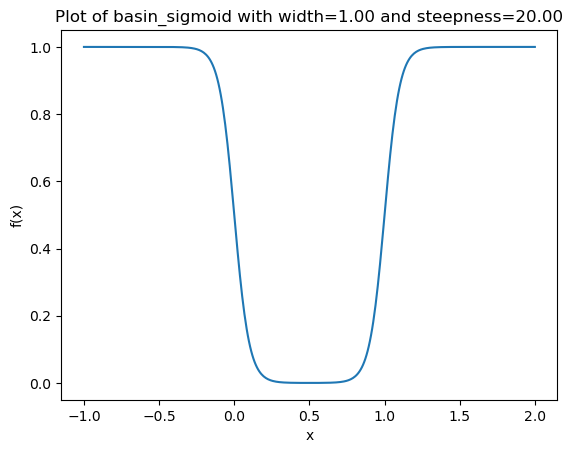

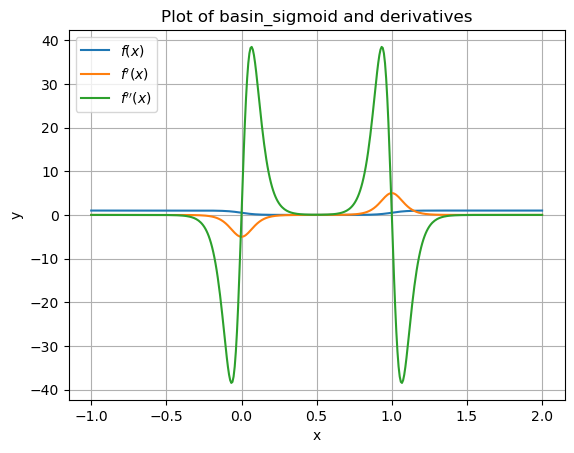

In [1]:

import matplotlib.pyplot as plt 
import numpy as np 
import math 




# Sigmoidal-basin function family, its gradients and second derivatives

# The family consists of a sum of two sigmoidal functions that form a basin.
# Steepness: beta, corresponds to temperature of the sigmoid
# Basin width: w, corresponds to gap between the inflection points of the two sigmoids.

def basin_sigmoid(beta, w, x):
    z1 = 1/(1 + np.exp(beta * x)) 
    z2 = 1/(1 + np.exp(beta * (w-x)))
    return z1+z2

def basin_sigmoid_derivative(beta, w, x):
    z1 = np.exp(beta * x)
    z2 = np.exp(beta * w) / math.pow(z1 + np.exp(beta * w), 2)
    z3 = 1 / math.pow(z1 + 1, 2)
    return beta * z1 * (z2 - z3)

def basin_sigmoid_second_derivative(beta, w, x):
    z0 = np.exp(beta * w)
    z1 = np.exp(beta * x)
    z2 = z0 * (z0-z1) / math.pow(z1 + z0, 3)
    z3 = (1-z1) / math.pow(z1 + 1, 3)
    return beta * beta * z1  * (z2 - z3)


# E.g. plot(20, 1)
def plot(beta, w):
    # test function plots
    x = np.linspace(-1, 2, 400) # Generates 400 points between -1 and 2
    y = basin_sigmoid(beta, w, x)
    y1 = [basin_sigmoid_derivative(beta, w, x1) for x1 in x]
    y2 = [basin_sigmoid_second_derivative(beta, w, x1) for x1 in x]
    
    # Plot the function
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Plot of basin_sigmoid with width=%.2f and steepness=%.2f" % (w, beta))
    plt.show()
    
    # Plot the function along with first and second derivatives
    plt.plot(x, y, label=r"$f(x)$")
    plt.plot(x, y1, label=r"$f'(x)$")
    plt.plot(x, y2, label=r"$f''(x)$")
    plt.legend(loc="upper left")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Plot of basin_sigmoid and derivatives")
    
    # Add grid lines
    plt.grid(True)
    
    # Show the plot
    plt.show()
    
    
beta = 20.0
w = 1.0

plot(beta, w)



As the above plots show, the second derivative can take large negative values outside of the basin given by $(0,w)$. The functions are always convex within the basin, and non-convex outside of it. Moreover, there is no absolute smoothness (Lipschitzness) bound, as by making the steepness $\beta$ large, we can arbitrarily increase the slope of the function $f(x)$ close the basin end points $x=0,x=w$.


### Both small and large learning rates fail


Now if the initial point is $x_0=-0.5$, gradient descent would be really slow initially due to the flatness (depending on the learning rate) but will move towards the "cliff" near $x=0$. Higher learning rates are generally better in this flat non-convex region.

Once we are at $x=-\epsilon$ for some small $\epsilon$, the situation reverses. Gradient descent steps with a fixed learning rate $\eta$ can easily overshoot (we can make $\beta$ large enough for any fixed $\eta$ so that this happens). So we really want to step very carefully in this region. The following piece of code illustrates this.

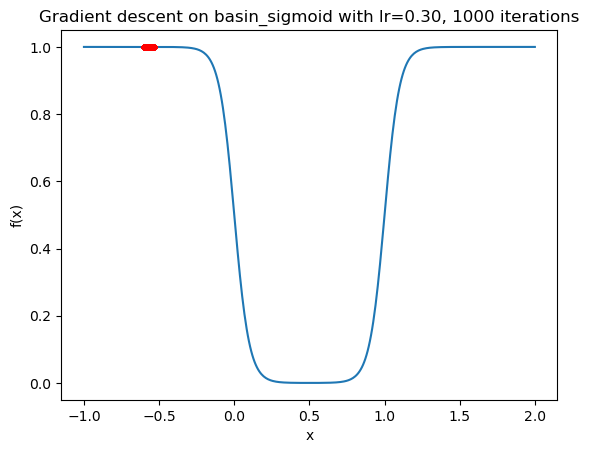

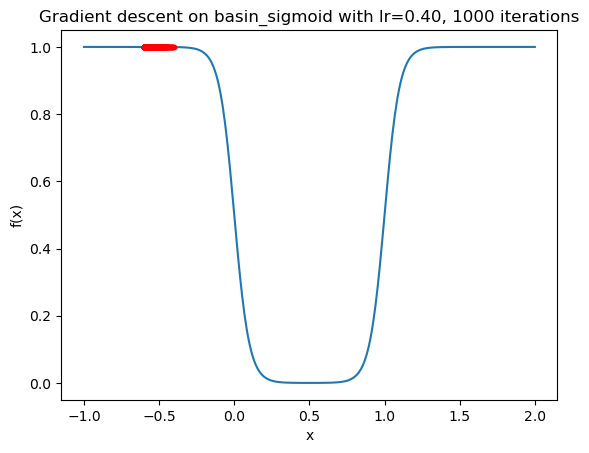

In [2]:
# gradient descent with initial point x0 and fixed step size eta
def grad_descent(x0, eta, iterations):
    points = [x0]
    # Gradient Descent optimization
    for i in range(iterations):
        x = points[i]
        
        # Compute the gradient at the current point
        grad = basin_sigmoid_derivative(beta, w, x)
        
        # Update x using the Gradient Descent formula
        x = x - eta * grad
        
        points.append(x)
    return points

# pts  = grad_descent(-1, 10, 10000)

def plot_gd(beta, w, x0, eta, iterations):
    # test function plots
    x = np.linspace(-1, 2, 400) # Generates 400 points between -1 and 2
    y = basin_sigmoid(beta, w, x)
    y1 = [basin_sigmoid_derivative(beta, w, x1) for x1 in x]
    y2 = [basin_sigmoid_second_derivative(beta, w, x1) for x1 in x]
    
    iterates = grad_descent(x0, eta, iterations)
    pts = [basin_sigmoid(beta, w, xi) for xi in iterates]
    
    # Plot the function
    plt.plot(x, y)
    plt.plot(iterates, pts, '.r', alpha=.8)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Gradient descent on basin_sigmoid with lr=%.2f, %i iterations" % (eta, iterations))
    plt.show()
    
    
x0 = -0.6

eta = 0.3
itrns = 1000

plot_gd(beta, w, x0, eta, itrns)

eta = 0.4
itrns = 1000

plot_gd(beta, w, x0, eta, itrns)

If the learning rate is too small, gradient descent gets stuck in the flat part. On the other hand, if it is large enough to make progress, it can get vastly overshoot once it gets to the steep portions near the edge of the basin.

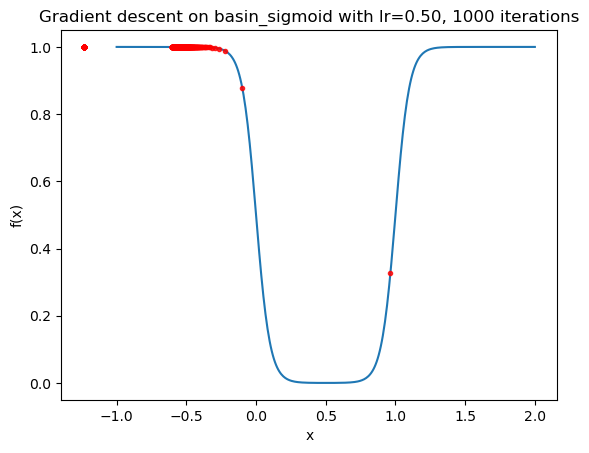

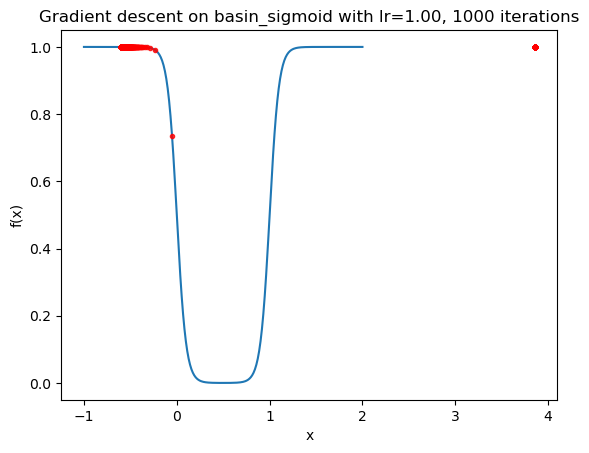

In [3]:
eta = 0.5
itrns = 1000

plot_gd(beta, w, x0, eta, itrns)

eta = 1.0
itrns = 1000

plot_gd(beta, w, x0, eta, itrns)


Unlike the nice regimes of convergence for small learning rates for smooth and convex functions, here convergence happens very irregularly---for example, if we luckily wander into the basin. However, we will see that it is very hard to predict which learning rate will work.

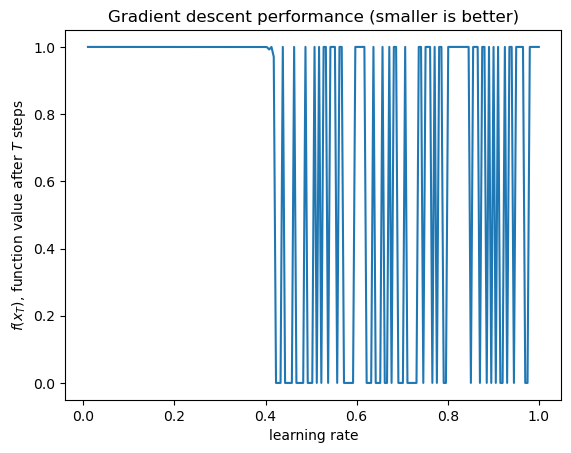

In [4]:
etas = np.linspace(0.01, 1.0, 200)
itrns = 1000
converged = []
for eta in etas:
    iterates = grad_descent(x0, eta, itrns)
    converged.append(basin_sigmoid(beta, w, iterates[-1]))

plt.plot(etas, converged)
plt.xlabel("learning rate")
plt.ylabel(r"$f(x_T)$, function value after $T$ steps")
plt.title("Gradient descent performance (smaller is better)")
plt.show()

### Newton's step fails too

Thus small learning rates just fail to make enough progress given a bounded number of total iterations. And large step sizes can converge or diverge depending upon where they land on the steep portion of the function. As an alternative, we study a regularized version of Newton's step next. In principle, Newton's step should at least work well once we are inside the basin i.e. within $x\in[0,w]$, but there is still a danger of overshooting in the non-convex parts of the "cliff" which are too steep and the second derivative points in the wrong direction. Formally, a regularized Newton's step is given by

$$x_{t+1}=x_t-(H+\alpha I)^{-1}\nabla f (x_t).$$

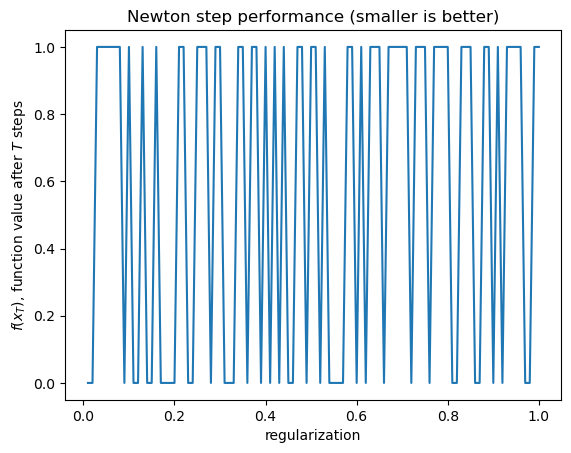

In [5]:

# Regularized Newton's step with initial point x0
def reg_newton_step(x0, alpha, iterations):
    points = [x0]
    for i in range(iterations):
        x = points[i]
        
        # Compute the gradient at the current point
        grad = basin_sigmoid_derivative(beta, w, x)
        
        # Compute the second derivative at the current point
        grad2 = basin_sigmoid_second_derivative(beta, w, x)
        
        # Update x using regularized Newton's step
        x = x - (1/(grad2 + alpha)) * grad
        
        points.append(x)
    return points

alphas = np.linspace(0.01, 1.0, 100)
itrns = 1000
converged = []
for alpha in alphas:
    iterates = reg_newton_step(x0, alpha, itrns)
    converged.append(basin_sigmoid(beta, w, iterates[-1]))

plt.plot(alphas, converged)
plt.xlabel("regularization")
plt.ylabel(r"$f(x_T)$, function value after $T$ steps")
plt.title("Newton step performance (smaller is better)")
plt.show()

### Newton-damped gradient descent---a novel, more effective approach

Clearly, regularized Newton's step has a similar behavior as gradient descent with sufficiently large learning rate. It is not clear which values of $\alpha$ one should set to achieve convergence, which seems highly sensitive to small changes in $\alpha$ and the initial point $x_0$.

We propose a novel version of Newton's method that overcomes the limitation of both gradient descent and regularized Newton's method above. In one dimension, our update step is given as

$$x_{t+1}=x_t-(f''(x_t)^2+\alpha)^{-1/2}f'(x_t).$$

A straightforward generalization to higher dimensions is stated below:

$$x_{t+1}=x_t-(H^TH+\alpha I)^{-1/2}\nabla f (x_t).$$

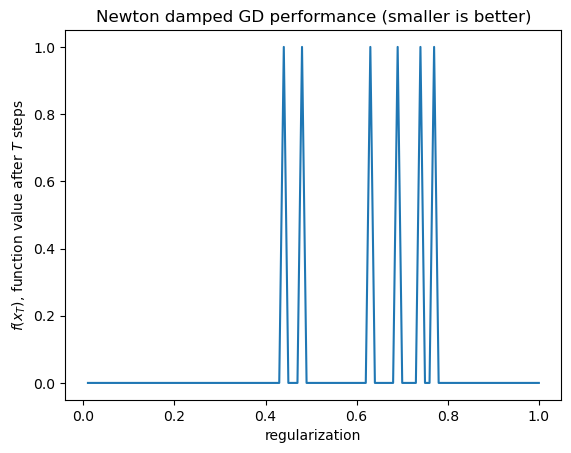

In [6]:

# Gradient descent + newton "damping" with initial point x0
def grad_newton_descent_l2(x0, alpha, iterations):
    points = [x0]
    # Gradient Descent optimization
    for i in range(iterations):
        x = points[i]
        
        # Compute the gradient at the current point
        grad = basin_sigmoid_derivative(beta, w, x)
        
        # Compute the second derivative at the current point
        grad2 = basin_sigmoid_second_derivative(beta, w, x)
        
        # Update x using the Gradient Descent formula
        x = x - math.sqrt(1/(grad2*grad2 + alpha)) * grad
        
        points.append(x)
    return points

    

alphas = np.linspace(0.01, 1.0, 100)
itrns = 1000
converged = []
for alpha in alphas:
    iterates = grad_newton_descent_l2(x0, alpha, itrns)
    converged.append(basin_sigmoid(beta, w, iterates[-1]))

plt.plot(alphas, converged)
plt.xlabel("regularization")
plt.ylabel(r"$f(x_T)$, function value after $T$ steps")
plt.title("Newton damped GD performance (smaller is better)")
plt.show()


Remarkably, our proposed method leads to a dramatic decrease in non-convergence. The intuition for this comes from the observation that Newton method only fails in the non-convex regions. Thus, by taking the squared second derivative, we avoid this issue and successfully damp the steep gradient steps by exploiting the observation that the magnitude of the second derivative is also large in these steep regions, which effectively counters the overshooting tendencies of vanilla gradient descent. In practice, the Hessian is often computationally expensive to compute and one use some approximation (e.g., Shampoo in deep learning or L-BFGS in constrained optimization).

### Conclusion

We expect these observations to prompt significant future research for the research on non-convex non-smooth optimization using gradient-based methods. Our initial experiments indicate the following:

* A combination of gradient descent carefully damped with Newton's step can lead to much better empirical convergence for the basin sigmoid function studied above. Our functional form of sigmoidal basins is naturally inspired from typical neural network activations.
* We only investigate one-dimensional functions that take a specific sigmoidal form for simplicity, but expect this phenomenon of steepness-induced overshooting and flatness-induced stagnation to happen in higher dimensions and for other functional forms. This is a basis for further empirical examination.
* The theory of convergence for non-smooth and non-convex functions should perhaps look at probability of convergence for random initializations instead of worst-case guarantees for arbitrary initializations. We suspect a smoothed analysis of this kind would potentially capture our empirical observations above well. Note that some prior work (e.g., Paquette et al., COLT 2021) has performed average case analysis for convergence of SGD with random initialization, but again only in convex and strongly-convex settings.